<a href="https://colab.research.google.com/github/sindhu213/Research-Papers/blob/master/src/neural_probabilistic_language_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# High-level overview of the architecture

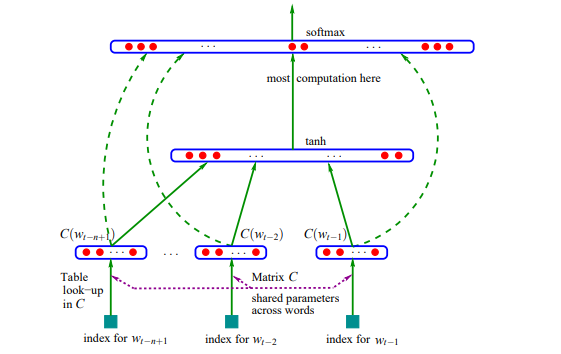

Image Source: [Bengio et al.(2003)](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

This takes sliding window approach. Let's say, window size is 3, then we take only 3 tokens at a time. After every generation step, we slide the window 1 unit towards the right. This way parameters are shared. Let's assume that vocab size is |V|. Formally, every source token is encoded into |V| dimensional one hot vector. This has atleast two flaws. One, it is computationally heavy for corpus with large vocabulary. Two, every two token is semantically and syntactically distinct, which is not-so intuitive.

To mitigate these problems, embedding matrix (Shape: |V| * m) is learned via neural network. Each row in the embedding matrix is mapped to a token in the vocabulary. By doing so, every token now belongs to a lower dimensional space. Plus, since the matrix is learned, the features vectors are now 'similar' for 'similar' tokens. 

Embedding mapping is represented by C. After that, mapped vectors are concatenated and fed to a neural network (feed-forward or RNN). The output of a neural network which is |V|-dimensional, is then normalized using softmax function and fed to loss function.

In [1]:
import re
import torch
from urllib.request import urlopen
from torch import nn,Tensor
from typing import List,Tuple
from torch.utils.data import DataLoader,random_split

# Preparing Data

In [2]:
link = "https://raw.githubusercontent.com/karpathy/makemore/master/names.txt"

with urlopen(link) as url:
  DATA = url.read().decode('ASCII').split()

In [3]:
## create vocabulary

## string to int (for encoding)
char2idx = {chr(i):i-97 for i in range(97,123)}
char2idx['<bos>'] = 26
char2idx['<eos>'] = 27

## int to string (for decoding)
idx2char = {val:key for key,val in char2idx.items()}

In [4]:
stoi = lambda LIST: [char2idx[char] for char in LIST]
itos = lambda LIST: [idx2char[integer] for integer in LIST]

## sanity check
print(stoi(['a','c']))
print(itos([0 ,2 ]))

[0, 2]
['a', 'c']


In [5]:
## maps a list of preceding characters of size WINDOW SIZE to the next character

def build_dataset(data,window_size,stride):
  training_egs = []
  for item in data:
    updated = ['<bos>',*item,'<eos>']
    for idx in range(0,len(updated)-window_size,stride):
      part = stoi(updated[idx:idx+window_size+1])
      training_egs.append((torch.tensor(part[:-1]),torch.tensor(part[-1:])))
  return training_egs

In [6]:
print("vocab_size: ",len(char2idx))
print("Total no. of training examples when STRIDE = 1: ",len(build_dataset(DATA,window_size=3,stride=1)))
print("Total no. of training examples when STRIDE = 2: ",len(build_dataset(DATA,window_size=3,stride=2)))

vocab_size:  28
Total no. of training examples when STRIDE = 1:  164080
Total no. of training examples when STRIDE = 2:  90154


In [7]:
def split_data(data,train_size:float):
  train_len = int(train_size * len(data))
  valid_len = len(data) - train_len
  
  train_data, valid_data = random_split(data,[train_len,valid_len],generator = torch.Generator().manual_seed(12345))
  return train_data, valid_data

In [8]:
WINDOW_SIZE = 3
STRIDE = 2

DATA_ENCODED = build_dataset(DATA,WINDOW_SIZE,STRIDE)
TRAIN_DATA, VALID_DATA = split_data(DATA_ENCODED,train_size=0.8)

print(f"length of training data: {len(TRAIN_DATA)},  dtype: {type(TRAIN_DATA)}")
print(f"length of validation data: {len(VALID_DATA)},  dtype: {type(VALID_DATA)}")

length of training data: 72123,  dtype: <class 'torch.utils.data.dataset.Subset'>
length of validation data: 18031,  dtype: <class 'torch.utils.data.dataset.Subset'>


In [9]:
BATCH_SIZE = 64

TRAIN_DL = DataLoader((TRAIN_DATA),batch_size=BATCH_SIZE,drop_last=True)
VALID_DL = DataLoader(VALID_DATA,batch_size=BATCH_SIZE,drop_last=True)

print("len(TRAIN_DL): ",len(TRAIN_DL))
print("len(VALID_DL): ",len(VALID_DL))

len(TRAIN_DL):  1126
len(VALID_DL):  281


# Model

## Model Definition

In [10]:
class LanguageModeling(nn.Module):      

  def __init__(self,vocab_size,embed_dim,hidden_dim):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size,embed_dim)
    self.module = nn.Sequential(
        nn.Linear(WINDOW_SIZE*embed_dim,hidden_dim),
        nn.Tanh(),
        nn.Linear(hidden_dim,vocab_size),
        nn.Softmax(dim=1)
    )

  def forward(self,input):
    """
    INPUT: 
      input: [batch_size,WINDOW_SIZE]
    OUTPUT:
      out: [batch_size,vocab_size]
    """
    ## out: [batch_size,WINDOW_SIZE,embed_dim]
    out = self.embedding(input)
    
    ## out: [batch_size,WINDOW_SIZE*embed_dim]
    out = out.view(BATCH_SIZE,-1)

    ## out: [batch_size,vocab_size]
    out = self.module(out)

    return out

## Model Initialization

In [11]:
VOCAB_SIZE = len(char2idx)
HIDDEN_DIM = 128
EMBED_DIM = 128

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LanguageModeling(VOCAB_SIZE,EMBED_DIM,HIDDEN_DIM)
model.to(device)

LanguageModeling(
  (embedding): Embedding(28, 128)
  (module): Sequential(
    (0): Linear(in_features=384, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=28, bias=True)
    (3): Softmax(dim=1)
  )
)

In [13]:
def count_parameters(model):
  return sum(param.numel() for param in model.parameters() if param.requires_grad)

print("Total no. of trainable paramters are: {:,}".format(count_parameters(model)))

Total no. of trainable paramters are: 56,476


## Model Training

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.05)

In [15]:
def train(data_iter):  
  model.train()
  epoch_loss = 0.0

  ## data: [batch_size,WINDOW_SIZE]
  ## label: [batch_size,1]
  for data,label in data_iter:
    optimizer.zero_grad()

    ## pred: [batch_size,vocab_size]
    pred = model(data)

    ## label : [batch_size]
    label = label.reshape(-1)

    ## loss: [batch_size]
    loss = loss_fn(pred,label)

    epoch_loss += loss.item() 
    loss.backward()
    optimizer.step()

  return epoch_loss/len(data_iter)

In [16]:
## same size as the variables in the train fn
def eval(data_iter):
  model.eval()
  epoch_loss = 0.0
  
  with torch.no_grad():
    for data,label in data_iter:
      pred = model(data)
      label = label.reshape(-1)
      loss = loss_fn(pred,label)
      epoch_loss += loss.item()

  return epoch_loss/len(data_iter)

In [17]:
NUM_EPOCHS = 20
for epoch in range(NUM_EPOCHS):
  train_loss = train(TRAIN_DL)
  eval_loss = eval(VALID_DL)
  print("EPOCH: ",epoch)
  print("-------- TRAINING LOSS: {: .4f} | VALIDATION LOSS: {: .4f}".format(train_loss,eval_loss))

EPOCH:  0
-------- TRAINING LOSS:  3.1531 | VALIDATION LOSS:  3.1476
EPOCH:  1
-------- TRAINING LOSS:  3.1421 | VALIDATION LOSS:  3.1468
EPOCH:  2
-------- TRAINING LOSS:  3.1347 | VALIDATION LOSS:  3.1368
EPOCH:  3
-------- TRAINING LOSS:  3.1341 | VALIDATION LOSS:  3.1431
EPOCH:  4
-------- TRAINING LOSS:  3.1411 | VALIDATION LOSS:  3.1393
EPOCH:  5
-------- TRAINING LOSS:  3.1340 | VALIDATION LOSS:  3.1289
EPOCH:  6
-------- TRAINING LOSS:  3.1342 | VALIDATION LOSS:  3.1398
EPOCH:  7
-------- TRAINING LOSS:  3.1333 | VALIDATION LOSS:  3.1405
EPOCH:  8
-------- TRAINING LOSS:  3.1319 | VALIDATION LOSS:  3.1361
EPOCH:  9
-------- TRAINING LOSS:  3.1390 | VALIDATION LOSS:  3.1491
EPOCH:  10
-------- TRAINING LOSS:  3.1369 | VALIDATION LOSS:  3.1381
EPOCH:  11
-------- TRAINING LOSS:  3.1350 | VALIDATION LOSS:  3.1368
EPOCH:  12
-------- TRAINING LOSS:  3.1327 | VALIDATION LOSS:  3.1454
EPOCH:  13
-------- TRAINING LOSS:  3.1398 | VALIDATION LOSS:  3.1413
EPOCH:  14
-------- TRAINING L